In [2]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

root_dir = "../../"
data_dir = "data"
# data_dir = "/export/gaon1/data/jteneggi/data/hshap/malaria"

explanation_dir = "explanations"
figure_dir = os.path.join(root_dir, "figures", "BBBC041")
os.makedirs(figure_dir, exist_ok=True)

df_train = pd.read_json(os.path.join(data_dir, "training.json"))
df_test = pd.read_json(os.path.join(data_dir, "test_cropped.json"))
frame = [df_train, df_test]
gt_df = pd.concat(frame, ignore_index=True)
image_name = []
for _, row in gt_df.iterrows():
    image_name.append(os.path.basename(row["image"]["pathname"]).split(".")[0])
gt_df["image_name"] = image_name
gt_df.set_index("image_name", inplace=True)

demo_image = "03cbfcf2-8da6-462c-b30d-16d63357371f"
demo_image_path = os.path.join("demo", f"{demo_image}.png")

sns.set_theme()
sns.set_context("paper", font_scale=1.8)

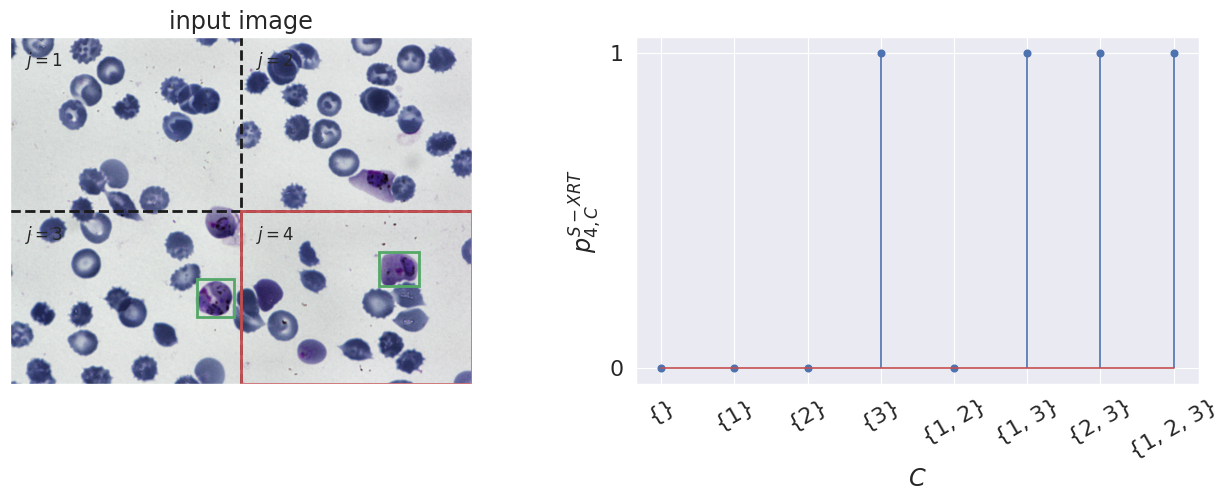

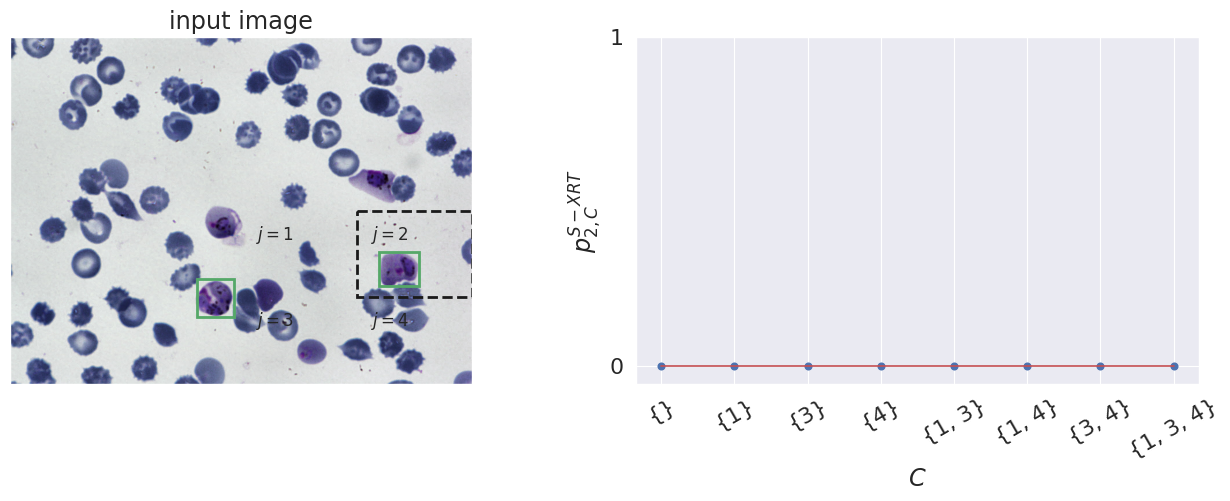

In [4]:
# code to reproduce Fig. 3
image = Image.open(demo_image_path)
for s in [800, 400]:
    _, axes = plt.subplots(1, 2, figsize=(16, 9 / 2))
    ax = axes[0]
    ax.imshow(image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title("input image")
    image_name = os.path.basename(demo_image_path).split(".")[0]
    cell = gt_df.at[image_name, "objects"]
    for c in cell:
        category = c["category"]
        if category == "trophozoite":
            bbox = c["bounding_box"]
            ul_r = bbox["minimum"]["r"]
            ul_c = bbox["minimum"]["c"]
            br_r = bbox["maximum"]["r"]
            br_c = bbox["maximum"]["c"]
            w = abs(br_c - ul_c)
            h = abs(br_r - ul_r)
            bbox = patches.Rectangle(
                (ul_c, ul_r),
                w,
                h,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(bbox)
    with open(os.path.join("demo", f"{image_name}_{s}.pkl"), "rb") as f:
        explanation = pickle.load(f)
    saliency_map, k, shaplit_map, p = explanation
    if s == 800:
        j = 3
        i = 1
        t0 = ax.text(50, 100, r"$j=1$", fontsize="x-small")
        t1 = ax.text(850, 100, r"$j=2$", fontsize="x-small")
        t2 = ax.text(50, 700, r"$j=3$", fontsize="x-small")
        t3 = ax.text(850, 700, r"$j=4$", fontsize="x-small")
        ax.axvline(800, c="k", linestyle="--", linewidth=2)
        ax.axhline(600, c="k", linestyle="--", linewidth=2)
        bbox = patches.Rectangle(
            (800, 600),
            800,
            600,
            linewidth=2,
            edgecolor="r",
            linestyle="-",
            facecolor="none",
            zorder=2,
        )
        ax.add_patch(bbox)
    if s == 400:
        j = 1
        i = 2
        bbox = patches.Rectangle(
            (1200, 600),
            400,
            300,
            linewidth=2,
            edgecolor="k",
            linestyle="--",
            facecolor="none",
        )
        ax.add_patch(bbox)
        t0 = ax.text(850, 700, r"$j=1$", fontsize="x-small")
        t1 = ax.text(1250, 700, r"$j=2$", fontsize="x-small")
        t2 = ax.text(850, 1000, r"$j=3$", fontsize="x-small")
        t3 = ax.text(1250, 1000, r"$j=4$", fontsize="x-small")
    p_j = p[i]
    c_j = [str(c) for c, _ in p_j[1]]
    p_j = [p for _, p in p_j[1]]
    ax = axes[1]
    ax.stem(range(len(p_j)), p_j)
    ax.set_xlabel(r"$C$")
    ax.set_ylabel(r"$p^{S-XRT}_{%d,C}$" % (j + 1))
    ax.set_xticks(range(len(c_j)))
    ax.set_yticks([0, 1])
    ax.set_xticklabels(c_j, rotation=30)
    plt.savefig(os.path.join(figure_dir, f"{image_name}_{s}.pdf"), bbox_inches="tight")
    plt.show()